In [13]:
import numpy as np
import numpy.linalg as nplin
import matplotlib.pyplot as plt
from matplotlib import cm
from multiprocessing import Pool as pool
from functools import partial
import timeit
from numpy.polynomial.polynomial import polyfit

In [14]:
# Parameters
maxIter = 1000 # 200000
Re      = 220
nx = 520 
ny = 180
ly = ny-1.0
q  = 9

cx = nx/4 
cy = ny/2 
r  = ny/9

uLB     = 0.04

nulb  = uLB*r/Re
omega = 1/(3*nulb+0.5)

# Multiprocesses: number of process
NumProc = 4 # given the parallelization method max is 9

In [15]:
# Context

# Exogenous velocity inlet
vel = np.fromfunction(lambda d,x,y: (1-d)*uLB*(1+1e-4*np.sin(y/ly*2*np.pi)),(2,nx,ny))

# Obstacle
# when obstacle = True, coordinate inside the cercle which is the obstacle
obstacle = np.fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))

# matrix for the directions in 2D
c = np.array([(x,y) for x in [0,-1,1] for y in [0,-1,1]])
# Define the unknown when obstacle
i1 = np.arange(q)[np.asarray([ci[0]<0  for ci in c])]
i2 = np.arange(q)[np.asarray([ci[0]==0 for ci in c])] 
i3 = np.arange(q)[np.asarray([ci[0]>0  for ci in c])] 

# weights
t = np.array([4/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/9, 1/36, 1/36])

In [16]:
# Initial values

def equilibrium_g(irho,iu):             
    cu   = np.dot(c,iu.transpose(1,0,2))
    usqr = iu[0]**2+iu[1]**2
    feqg = np.zeros((q,nx,ny))
    for i in range(q): 
        feqg[i,:,:] = irho*t[i] + irho*t[i]*( 3*cu[i] + (9/2)*cu[i]**2 - (3/2)*usqr )
    return feqg

feq = equilibrium_g(1,vel); 
fin = feq.copy()

## This function parallelises the equilibrium function

In [17]:
def equilibrium(iqn,irho,iu):
    cu   = np.dot(c,iu.transpose(1,0,2))    
    usqr = iu[0]**2+iu[1]**2
    ifeq = np.zeros((nx,ny))
    ifeq[:,:] = irho*t[iqn] + irho*t[iqn]*( 3*cu[iqn] + (9/2)*cu[iqn]**2 - (3/2)*usqr )
    return ifeq

## This function parallelises the update when meeting the obstacle

In [18]:
def Fobstacle(iqf,iobstacle,ifin,ifout):
    indexf = c.tolist().index((-c[iqf]).tolist())
    ifout[iqf,iobstacle] = ifin[indexf,iobstacle] 
    ifoutn = np.zeros((nx,ny))
    ifoutn[:,:] = ifout[iqf,:,:]
    return ifoutn

## This function parallelises the update when meeting obstacle and the diffusion


In [19]:
def Fobstaclediff(iqf,iobstacle,ifin,ifout):
    indexf = c.tolist().index((-c[iqf]).tolist())
    ifout[iqf,iobstacle] = ifin[indexf,iobstacle] 
    ifoutn = np.zeros((nx,ny))
    ifoutn[:,:] = ifout[iqf,:,:]
    amat = np.roll(ifout[iqf,:,:],c[iqf,0],axis=0)
    ifin[iqf,:,:] = np.roll(amat,c[iqf,1],axis=1)        
    ifinn = np.zeros((nx,ny))
    ifinn[:,:] = ifin[iqf,:,:]
    return ifinn

In [20]:
pp  = pool(NumProc) # number of processes

0


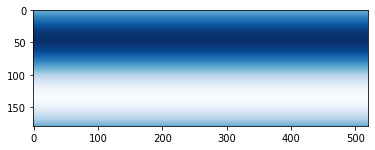

0.9019369759917026
100


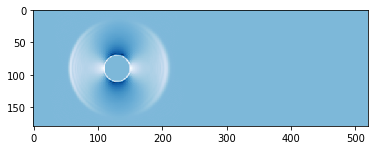

78.33737658099562
200


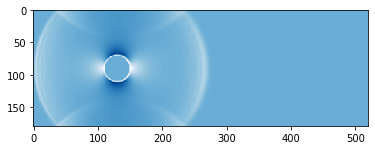

147.1418728139979
300


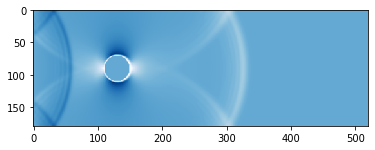

220.00294189499982
400


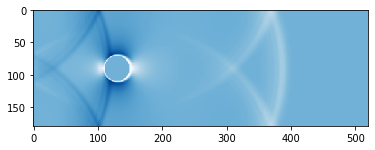

294.91449729200394
500


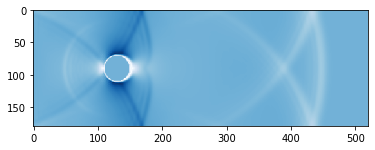

368.13912428199546
600


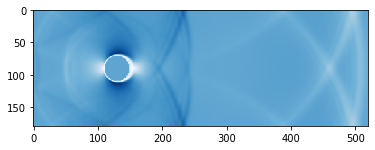

441.95358540500456
700


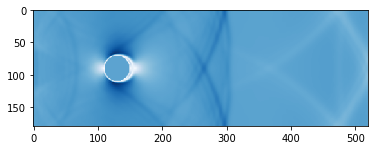

520.5814995349938
800


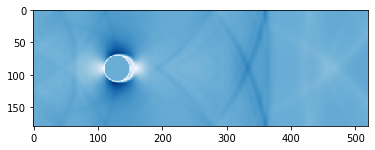

604.9660997399915
900


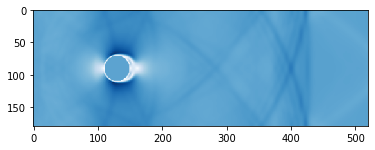

683.444013647997
[  0. 100. 200. 300. 400. 500. 600. 700. 800. 900.]
[  0.90193698  78.33737658 147.14187281 220.00294189 294.91449729
 368.13912428 441.95358541 520.58149953 604.96609974 683.44401365]


TypeError: expected x and y to have same length

In [21]:
# Solution
timelpool = np.zeros(maxIter//100)
iterl = np.zeros(maxIter//100)
start = timeit.default_timer()
for Iter in range(maxIter):
    fin[i1,-1,:] = fin[i1,-2,:] 
    rho = sum(fin)
    u   = np.dot(c.transpose(), fin.transpose((1,0,2)))/rho 
    u[:,0,:] = vel[:,0,:] 
    rho[0,:] = 1/(1-u[0,0,:]) * (sum(fin[i2,0,:])+2.*sum(fin[i1,0,:]))

    lambda_equil = partial(equilibrium, irho=rho, iu=u)    
    res = pp.map(lambda_equil, list(np.arange(0,9,1)) ) 
    feq = np.asarray(res)

    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]

    fout = fin - omega * (fin - feq)

# No pool version
#    noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)]    
#    for i in range(q): 
#        fout[i,obstacle] = fin[noslip[i],obstacle]    
#    for i in range(q): 
#        amat = np.roll(fout[i,:,:],c[i,0],axis=0)
#        fin[i,:,:] = np.roll(amat,c[i,1],axis=1)        

# Pool version 1
#    lambda_fout = partial(Fobstacle, iobstacle=obstacle, ifin=fin, ifout=fout)
#    res2 = pp.map(lambda_fout, list(np.arange(0,9,1)))
#    fout = np.asarray(res2)
#    for i in range(q): 
#        amat = np.roll(fout[i,:,:],c[i,0],axis=0)
#        fin[i,:,:] = np.roll(amat,c[i,1],axis=1)        

# Pool version 2
    lambda_fin = partial(Fobstaclediff, iobstacle=obstacle, ifin=fin, ifout=fout)
    res3 = pp.map(lambda_fin, list(np.arange(0,9,1)))
    fin  = np.asarray(res3)

    #---------------------------- 
    # Plots
    #----------------------------
    if (Iter%100==0): 
        plt.clf(); 
        plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.Blues)    
        print(Iter)
        #plt.savefig("velmp."+str(Iter/100).zfill(4)+".png", dpi=200)
        plt.show() 
        stop = timeit.default_timer()
        T = stop-start
        print(T)
        timelpool[Iter//100]=T
        iterl[Iter//100]=Iter
print(iterl)
print(timelpool)
%store -r timel
# Applying a linear fit with polyfit
b, m = polyfit(iterl, timel, 1)
c, n = polyfit(iterl, timelpool, 1)
plt.xlabel('iterations')
plt.ylabel('time (s)')
plt.plot(iterl, timelpool, '.', label='parallelised')
plt.plot(iterl, timel, '.', label='vectorized')
plt.plot(iterl, b + m * iterl, '-')
plt.plot(iterl, c + n * iterl, '-')
plt.legend(bbox_to_anchor=(0.3, 0.9), loc=1, borderaxespad=0.)
plt.show()

In [25]:
timel.shape

(500,)

In [ ]:
%store -r timel
print(timel)

In [ ]:
# Fit with polyfit
b, m = polyfit(iterl, timel, 1)
c, n = polyfit(iterl, timelpool, 1)
plt.xlabel('iterations')
plt.ylabel('time (s)')
plt.plot(iterl, timelpool, '.', label='parallelised')
plt.plot(iterl, timel, '.', label='vectorized')
plt.plot(iterl, b + m * iterl, '-')
plt.plot(iterl, c + n * iterl, '-')
plt.legend(bbox_to_anchor=(0.3, 0.9), loc=1, borderaxespad=0.)
plt.show()

In [2]:
%store -r timel
print(timel)

[ 2.92921639 17.34190701 31.62948479]
